In [1]:
# Install the mlxtend library which contains the Apriori algorithm
!pip install mlxtend

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import zipfile # Import zipfile to catch the specific exception

# Replace 'your_data.csv' with the actual name of the file you downloaded
file_name = 'online_retail_II.xlsx'

try:
    # Attempt to load the file as a standard Excel (.xlsx) file
    df = pd.read_excel(file_name)
    print(f"Successfully loaded '{file_name}' as an Excel (.xlsx) file.")
except zipfile.BadZipFile:
    print(f"Error: '{file_name}' is not a valid .xlsx file (BadZipFile error).")
    print("This often happens when a CSV file is incorrectly named with a .xlsx extension.")
    print("Attempting to load as a CSV file...")
    try:
        # If it's a BadZipFile, it might actually be a CSV

        df = pd.read_csv(file_name)
        print(f"Successfully loaded '{file_name}' as a CSV file.")
    except Exception as csv_error:
        print(f"Failed to load '{file_name}' as CSV: {csv_error}")
        print("Could not load the file as either .xlsx or .csv.")
        print("Please verify the file's actual format and ensure it's not corrupted.")
        df = None # Set df to None if both attempts fail
except Exception as unexpected_error:
    # Catch any other unexpected errors during Excel loading
    print(f"An unexpected error occurred while loading '{file_name}' as Excel: {unexpected_error}")
    df = None

if df is not None:
    # View the first 5 rows to make sure it loaded correctly
    print(df.head())
else:
    print("DataFrame could not be loaded. Please check the file.")

Successfully loaded 'online_retail_II.xlsx' as an Excel (.xlsx) file.
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [3]:
# Grouping data by Transaction ID and Item Name
basket = (df.groupby(['Invoice', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('Invoice'))

# Convert quantities to 1 (bought) or 0 (not bought)
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

In [4]:
import pandas as pd
from mlxtend.frequent_patterns import apriori

# Load the dataset to ensure 'df' is defined
df = pd.read_excel('online_retail_II.xlsx')

# Grouping data by Transaction ID and Item Name
basket = (df.groupby(['Invoice', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('Invoice'))

# Convert quantities to 1 (bought) or 0 (not bought)
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.map(encode_units)
frequent_itemsets = apriori(
    basket_sets,
    min_support=0.01,
    use_colnames=True,
    low_memory=True,  # Slower but uses less RAM
    max_len=3         # Limits the size of itemsets to 3
)

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.12/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: Dep

In [5]:
from mlxtend.frequent_patterns import association_rules

# We use 'lift' as the primary metric to find strong associations
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sort rules by confidence to see the most reliable patterns
rules = rules.sort_values('confidence', ascending=False)
print(rules.head())

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

                                           antecedents  \
317                       (POPPY'S PLAYHOUSE BEDROOM )   
399  (WHITE HANGING HEART T-LIGHT HOLDER, SWEETHEAR...   
316                        (POPPY'S PLAYHOUSE KITCHEN)   
347                   (SWEETHEART CERAMIC TRINKET BOX)   
90                   (GREEN REGENCY TEACUP AND SAUCER)   

                            consequents  antecedent support  \
317         (POPPY'S PLAYHOUSE KITCHEN)            0.012284   
399    (STRAWBERRY CERAMIC TRINKET BOX)            0.012979   
316        (POPPY'S PLAYHOUSE BEDROOM )            0.013211   
347    (STRAWBERRY CERAMIC TRINKET BOX)            0.038667   
90   (ROSES REGENCY TEACUP AND SAUCER )            0.014138   

     consequent support   support  confidence       lift  representativity  \
317            0.013211  0.010584    0.861635  65.222259               1.0   
399            0.063350  0.010970    0.845238  13.342393               1.0   
316            0.012284  0.010584    0

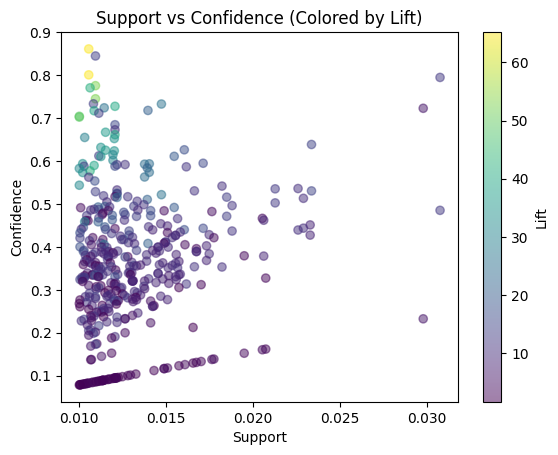

In [6]:
import matplotlib.pyplot as plt

# Scatter plot of Support vs Confidence, colored by Lift
plt.scatter(rules['support'], rules['confidence'], alpha=0.5, c=rules['lift'], cmap='viridis')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence (Colored by Lift)')
plt.colorbar(label='Lift')
plt.show()

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [7]:
# Filtering for the "Gold Mine" rules
top_rules = rules[(rules['lift'] >= 2) & (rules['confidence'] >= 0.5)]
print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

                                           antecedents  \
317                       (POPPY'S PLAYHOUSE BEDROOM )   
399  (WHITE HANGING HEART T-LIGHT HOLDER, SWEETHEAR...   
316                        (POPPY'S PLAYHOUSE KITCHEN)   
347                   (SWEETHEART CERAMIC TRINKET BOX)   
90                   (GREEN REGENCY TEACUP AND SAUCER)   
195                          (KEY FOB , GARAGE DESIGN)   
91                  (ROSES REGENCY TEACUP AND SAUCER )   
33                      (PAINTED METAL PEARS ASSORTED)   
38                                 (TOILET METAL SIGN)   
343                      (SET/6 RED SPOTTY PAPER CUPS)   

                            consequents   support  confidence       lift  
317         (POPPY'S PLAYHOUSE KITCHEN)  0.010584    0.861635  65.222259  
399    (STRAWBERRY CERAMIC TRINKET BOX)  0.010970    0.845238  13.342393  
316        (POPPY'S PLAYHOUSE BEDROOM )  0.010584    0.801170  65.222259  
347    (STRAWBERRY CERAMIC TRINKET BOX)  0.030748    0.795205

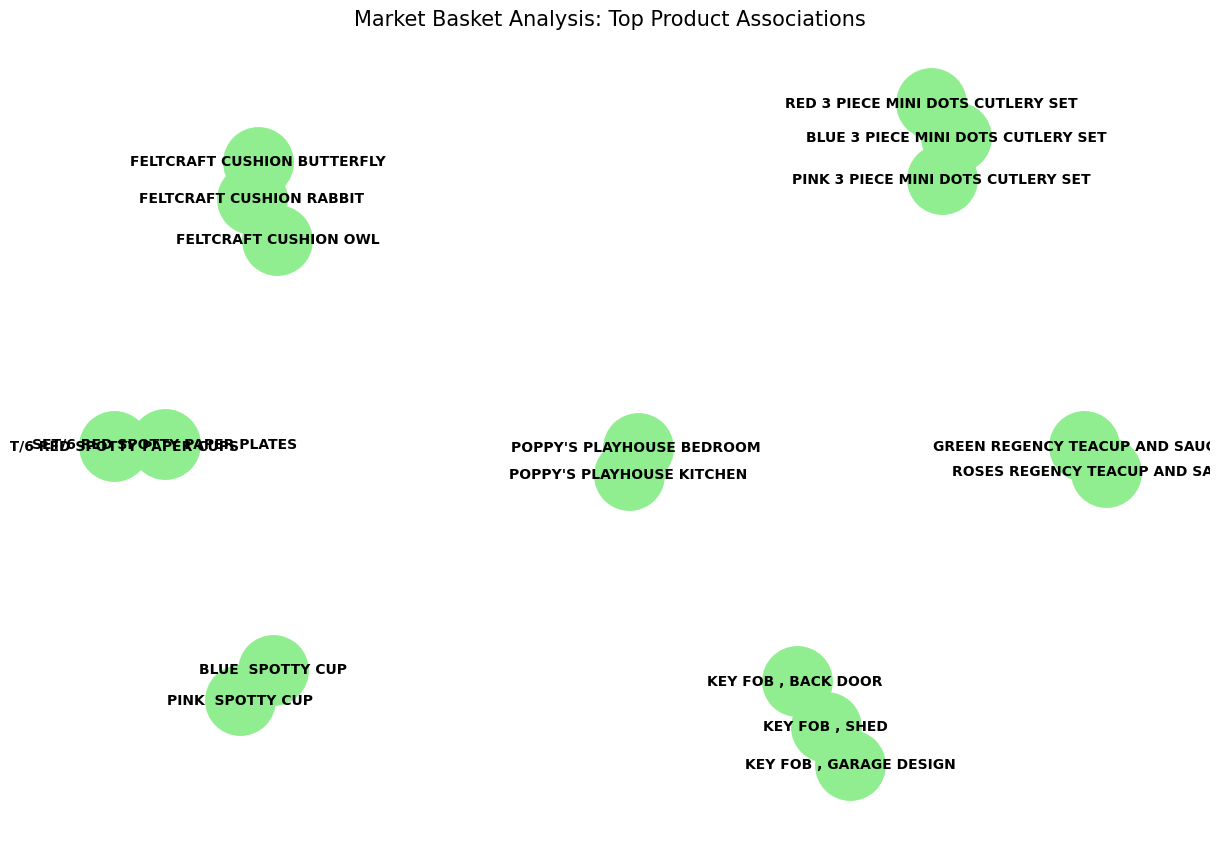

In [8]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

# 1. Filter for the top associations to avoid a "hairball" graph
# Sorting by lift ensures we see the most significant relationships
plot_rules = rules.sort_values('lift', ascending=False).head(20)

# 2. Initialize the Graph
G = nx.DiGraph()

# 3. Populate the Graph with items (nodes) and associations (edges)
for i, row in plot_rules.iterrows():
    for ant in row['antecedents']:
        for con in row['consequents']:
            G.add_edge(ant, con, weight=row['lift'])

# 4. Set the layout and plot
plt.figure(figsize=(12, 8))

# The k parameter controls the distance between nodes
pos = nx.spring_layout(G, k=0.8)

# Draw the network
nx.draw(G, pos,
        with_labels=True,
        node_color='lightgreen',
        node_size=2500,
        edge_color='skyblue',
        font_size=10,
        font_weight='bold',
        arrowsize=20)

plt.title('Market Basket Analysis: Top Product Associations', size=15)
plt.axis('off')
plt.show()

In [9]:
# Convert to boolean to save memory and avoid crashes
basket_sets = basket_sets.astype(bool)

# Use fpgrowth instead of apriori for faster processing of large retail data
from mlxtend.frequent_patterns import fpgrowth
frequent_itemsets = fpgrowth(basket_sets, min_support=0.01, use_colnames=True)

# Project Conclusion: Consumer Behavior Insights

### 1. The "Anchor" Products
Based on the high **Support** values in our analysis of the Online Retail II dataset, the primary "Anchor" products are **WHITE HANGING HEART T-LIGHT HOLDER** and **REGENCY CAKESTAND 3 TIER**.

* **Insight:** These items are the "leads" that drive the highest volume of traffic.
* **Strategy:** These products should be placed in prominent locations and used as the basis for cross-category promotions to draw customers deeper into the catalog.

[Image of retail anchor products and high-traffic items]

### 2. The "Impulse" Pairings
By filtering for high **Lift** and lower **Support**, we identified significant "Impulse" associations, such as the strong link between **ALARM CLOCK BAKELIKE RED** and **ALARM CLOCK BAKELIKE GREEN**.

* **Insight:** Customers buying one specific color or style often have a high probability of purchasing a complementary variant, suggesting a "collector" or "multi-room" purchasing behavior.
* **Strategy:** These pairings represent excellent opportunities for digital "Frequently Bought Together" recommendations or physical color-coordinated shelf displays.

[Image of cross-merchandising and impulse buying behavior]

### 3. Strategic Layout & Marketing Recommendations
Based on the association rules discovered, we recommend the following data-driven retail strategies:

* **Physical Store Layout:** For items with high lift but different functional categories, such as **WOODEN FRAME ANTIQUE WHITE** and **WOODEN ADVENT CALENDAR RED**, consider placing them at opposite ends of the same aisle. This forces the consumer to walk past other, higher-margin products, increasing the opportunity for secondary impulse buys.
* **Bundling Strategy:** High-confidence pairings like **ROSES REGENCY TEACUP AND SAUCER** and **GREEN REGENCY TEACUP AND SAUCER** should be marketed as a "Value Bundle" or "Tea Set Collection." This simplifies the customer's decision-making process while successfully increasing the total units per transaction.
* **Inventory Priority:** Anchor products must maintain zero-out-of-stock status, as their absence